In [31]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import Ridge
import tensorflow as tf
from tensorflow import keras
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from functions import loadData, expand_mean, CAMELSrun, visualization, backtest, standardtest, print_model_weights_and_biases, permutation_importance

In [37]:
def createModel(x_shape, y_shape):
    model = Sequential()
    # Add LSTM layers
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_shape, y_shape), kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.1))
    model.add(LSTM(units=50, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(1))  # Output layer for streamflow prediction

    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mean_squared_error'])


    # Summary to see the architecture
    model.summary()
    return model

In [38]:
df, X, Y = CAMELSrun('04045500', 3, 7, 'Flow+1', True)

print(X.shape[0])

c:\Users\Abdullah Usmani\Documents\FloodLearning\functions.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
c:\Users\Abdullah Usmani\Documents\FloodLearning\functions.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


42


In [39]:
model = createModel(42, 1)

c:\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 42, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 42, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
predictions, datetime1 = backtest(df, model, X, Y, 540, 60, None)
y_pred = predictions["prediction"]
y_test = predictions["actual"]

y_pred = np.maximum(y_pred, 0)  # Ensure no negative predictions
y_pred = np.minimum(y_pred, np.max(y_test) * 1.1)  # Cap predictions at 10% above max value of y_test

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 1.3798 - mean_squared_error: 0.6008 - val_loss: 3.0264 - val_mean_squared_error: 2.3721
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.0704 - mean_squared_error: 0.4520 - val_loss: 2.7463 - val_mean_squared_error: 2.2286
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.9769 - mean_squared_error: 0.4863 - val_loss: 2.2979 - val_mean_squared_error: 1.8836
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.7608 - mean_squared_error: 0.3663 - val_loss: 1.8198 - val_mean_squared_error: 1.4796
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.5605 - mean_squared_error: 0.2354 - val_loss: 1.2541 - val_mean_squared_error: 0.9725
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.4931 - mean_squared_error: 0.2238 - val_loss: 0.9377 - val_mean_squared_error: 0.7034
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3924 - mean_squared_error: 0.1688 - val_loss: 0.9222 - va

MAE: 197.45 m3/s
MSE: 111009.84 m3/s
RMSE: 333.18 m3/s
MAPE: 0.29%
Accuracy: 99.715%
R2: 0.8433


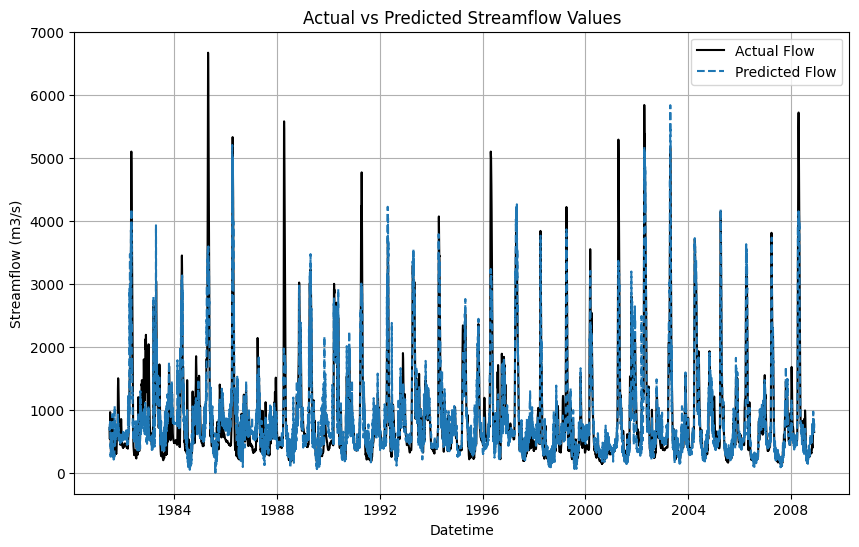

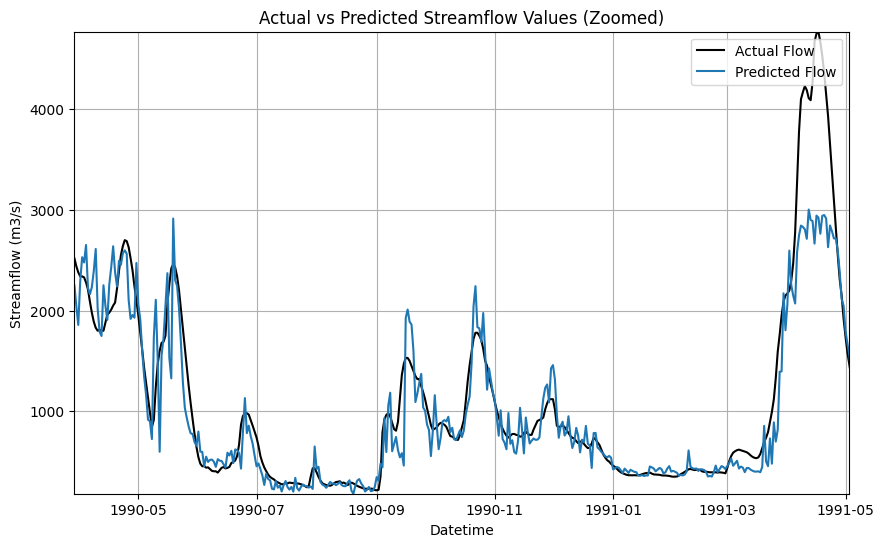

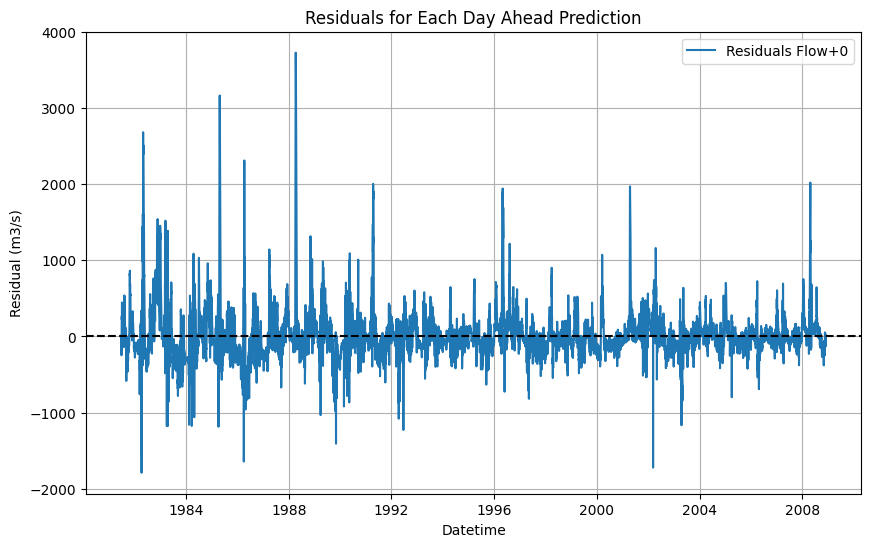

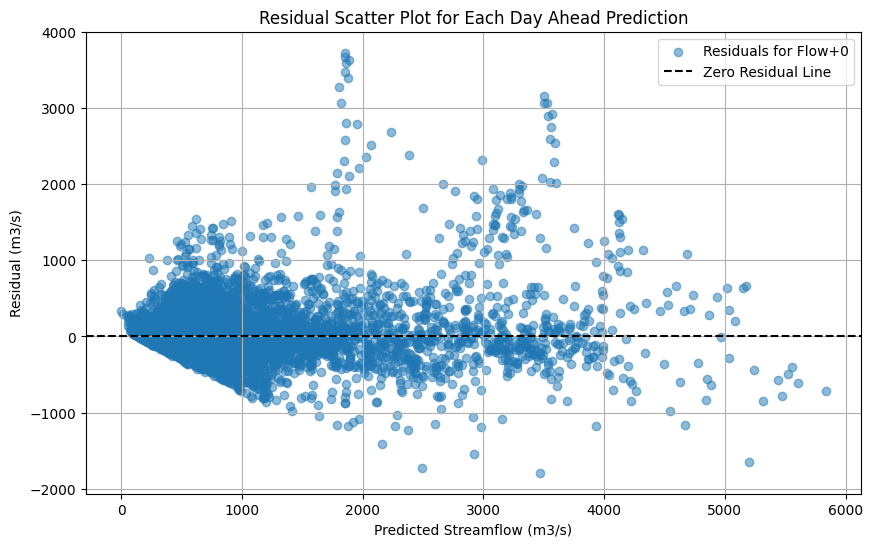

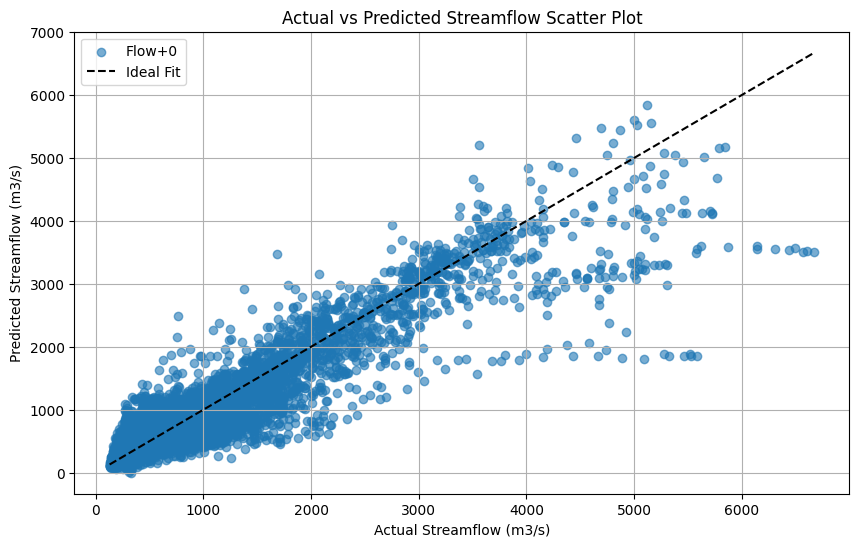

Layer 1: lstm_4
  Weights shape: (1, 200)
  Weights: [[-1.13186566e-02  1.92644875e-02  1.67802721e-02  4.17758385e-03
   1.82004143e-02 -1.75027410e-03 -2.00658236e-02  1.69484806e-03
   2.24181563e-02 -7.08083017e-03  1.13153243e-02  2.15389393e-03
  -9.41594318e-03  8.10160022e-03 -1.58708077e-02  8.84124823e-03
  -2.46459269e-03  1.27246417e-02 -3.61207463e-02 -4.02855803e-05
   1.74296368e-02 -6.53972663e-03  5.00350667e-04  5.08466922e-02
   1.00024883e-02 -2.24979641e-03 -1.44203566e-03 -8.35691672e-03
   5.71862049e-03  7.44507648e-04 -7.22026103e-04  2.20037950e-03
  -3.53514105e-02 -1.42598068e-02  1.13379676e-02  1.46276811e-02
   4.83928295e-03  2.09862590e-02  3.11507378e-02 -1.01803849e-02
   8.71079974e-03  1.52524123e-02 -1.88871834e-03  5.68506587e-03
   1.06545035e-02 -3.32240667e-03 -1.98211540e-02  1.33846318e-02
   4.87889443e-03  9.48847737e-03 -9.24190786e-03 -9.03366785e-03
  -9.76094883e-03 -4.57363529e-03 -5.91827556e-03 -1.62301958e-02
   1.66029367e-03  1.25

In [42]:
visualization(datetime1, y_pred, y_test, 3200,3600)
print_model_weights_and_biases(model)

In [44]:
df, X, Y = CAMELSrun('13340000', 3, 7, 'Flow+1', False)

c:\Users\Abdullah Usmani\Documents\FloodLearning\functions.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
c:\Users\Abdullah Usmani\Documents\FloodLearning\functions.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


In [45]:
predictions1, datetime2 = backtest(df, model, X, Y, 365, 60, None)

y_pred1 = predictions1["prediction"]
y_test1 = predictions1["actual"]

y_pred1 = np.maximum(y_pred1, 0)  # Ensure no negative predictions1
y_pred1 = np.minimum(y_pred1, np.max(y_test1) * 1.1)  # Cap predictions1 at 10% above max value of y_test

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0953 - mean_squared_error: 0.0863 - val_loss: 0.1334 - val_mean_squared_error: 0.1242
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1268 - mean_squared_error: 0.1174 - val_loss: 0.0608 - val_mean_squared_error: 0.0508
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0655 - mean_squared_error: 0.0553 - val_loss: 0.0544 - val_mean_squared_error: 0.0436
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0843 - mean_squared_error: 0.0733 - val_loss: 0.0777 - val_mean_squared_error: 0.0666
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1017 - mean_squared_error: 0.0907 - val_loss: 0.0507 - val_mean_squared_error: 0.0399
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0760 - mean_squared_error: 0.0652 - val_loss: 0.0594 - val_mean_squared_error: 0.0487
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0814 - mean_squared_error: 0.0706 - val_loss: 0.0676 - va

MAE: 1830.89 m3/s
MSE: 9343626.49 m3/s
RMSE: 3056.73 m3/s
MAPE: 0.36%
Accuracy: 99.64%
R2: 0.9107


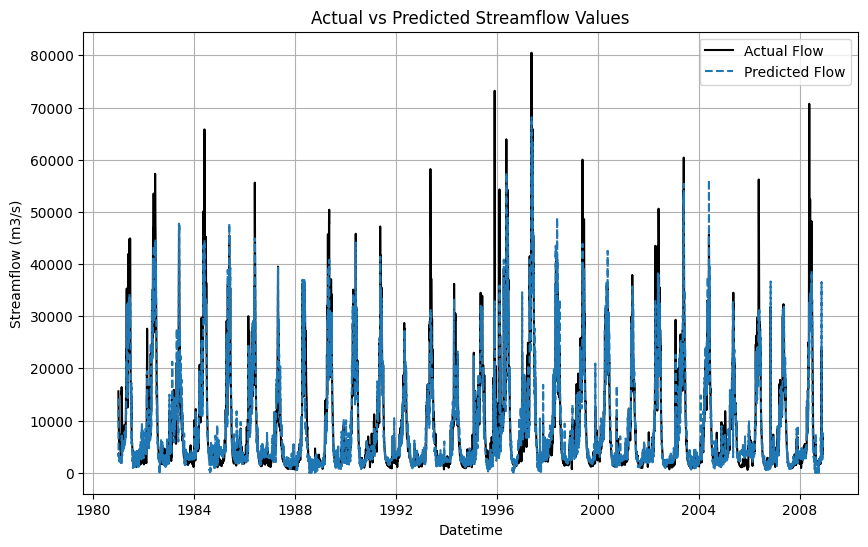

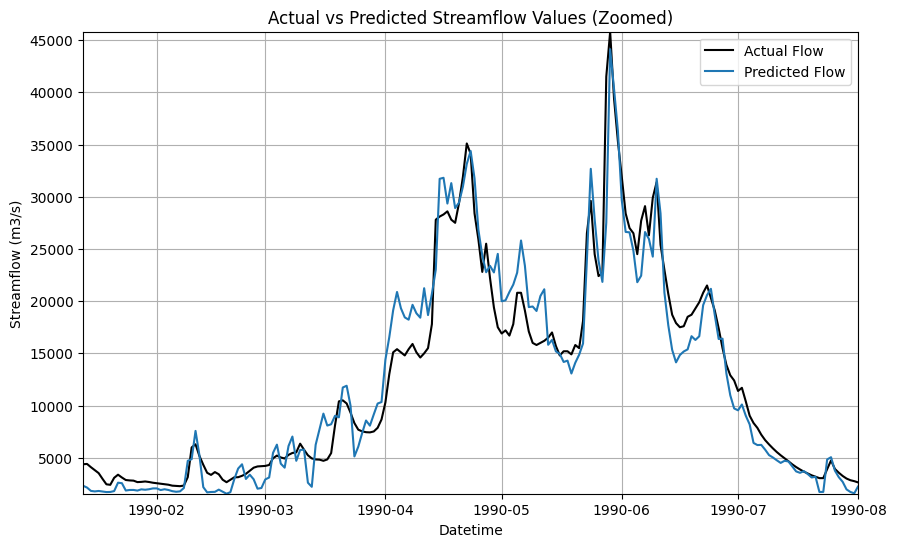

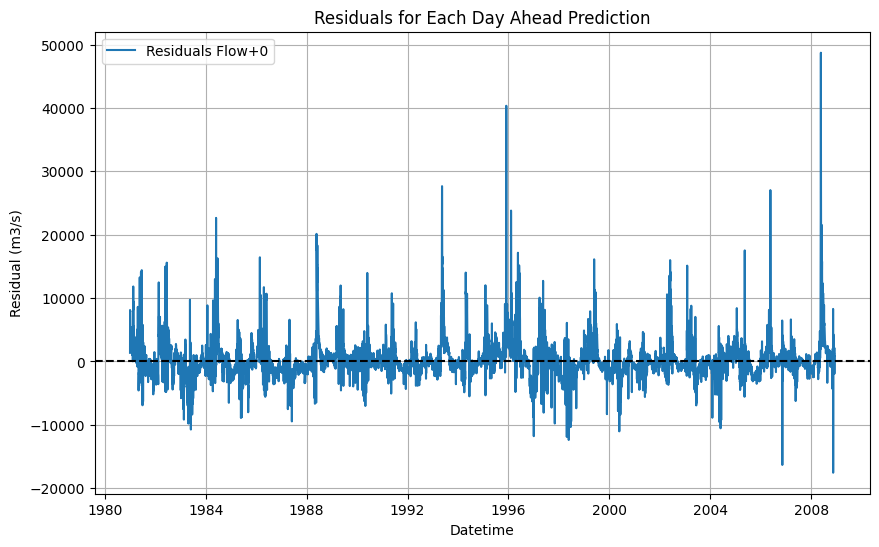

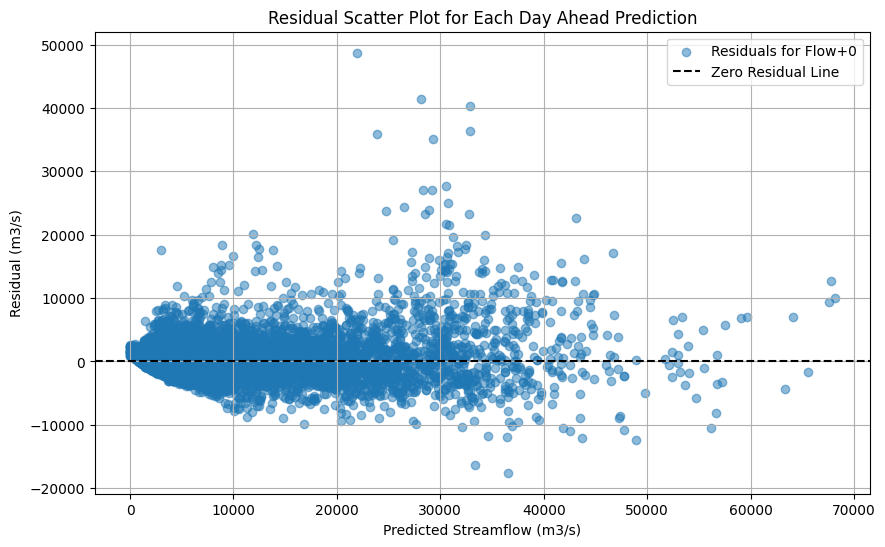

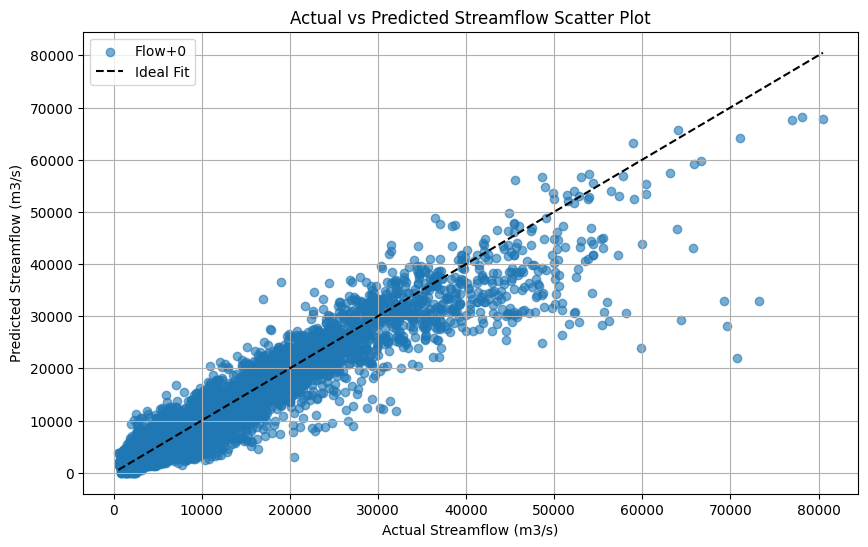

Layer 1: lstm_4
  Weights shape: (1, 200)
  Weights: [[-2.19775718e-02  5.99042233e-03 -3.36284749e-02 -8.84689111e-03
  -3.73072587e-02  5.03513776e-03  7.29766907e-03  8.12503602e-03
  -2.33009886e-02 -1.10676996e-02 -1.79088060e-02  6.97256858e-03
  -5.95514849e-03 -2.35666102e-03 -3.48237045e-02 -8.05572979e-03
  -4.92363516e-03 -4.44587087e-03 -6.30296543e-02  2.65119895e-02
  -9.42330062e-03 -9.72685870e-03 -1.16002532e-02  1.78861134e-02
  -1.39252730e-02 -9.17690108e-04 -8.84405151e-03 -1.23549160e-02
  -1.14365201e-02 -2.78114714e-03 -4.28233435e-03 -1.52982296e-02
   4.49754670e-03  1.34794461e-02  4.32635704e-03  1.00086173e-02
  -3.11483000e-03 -1.15746055e-02  1.04113054e-02 -1.74703393e-02
  -1.79404039e-02 -4.72726708e-04 -7.05896551e-03 -5.97353000e-03
  -1.32962596e-02 -7.48617249e-03  1.40537256e-02 -1.25816250e-02
  -1.02625899e-02  1.44379062e-03 -1.01532741e-02 -3.76774254e-03
   2.35849638e-02 -2.54148315e-03  1.98610462e-02 -8.10418371e-03
   7.27186352e-03 -7.11

In [47]:
visualization(datetime2, y_pred1, y_test1, 3300, 3500)
print_model_weights_and_biases(model)

In [48]:
df, X, Y = CAMELSrun('05131500', 3, 7, 'Flow+2', False)

predictions2, datetime3 = backtest(df, model, X, Y, 540, 60, None)

y_pred2 = predictions2["prediction"]
y_test2 = predictions2["actual"]

y_pred2 = np.maximum(y_pred2, 0)  # Ensure no negative predictions2
y_pred2 = np.minimum(y_pred2, np.max(y_test2) * 1.1)  # Cap predictions2 at 10% above max value of y_test


c:\Users\Abdullah Usmani\Documents\FloodLearning\functions.py:23: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df1 = pd.read_csv(f'{flow}', delim_whitespace=True, header=None)
c:\Users\Abdullah Usmani\Documents\FloodLearning\functions.py:27: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df2 = pd.read_csv(f'{meta}', skiprows=3, delim_whitespace=True)


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0947 - mean_squared_error: 0.0861 - val_loss: 0.7640 - val_mean_squared_error: 0.7545
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0697 - mean_squared_error: 0.0603 - val_loss: 0.7793 - val_mean_squared_error: 0.7699
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0727 - mean_squared_error: 0.0632 - val_loss: 0.6339 - val_mean_squared_error: 0.6243
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0450 - mean_squared_error: 0.0354 - val_loss: 0.5280 - val_mean_squared_error: 0.5183
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0661 - mean_squared_error: 0.0566 - val_loss: 0.5855 - val_mean_squared_error: 0.5761
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0511 - mean_squared_error: 0.0418 - val_loss: 0.5621 - val_mean_squared_error: 0.5528
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0476 - mean_squared_error: 0.0382 - val_loss: 0.5605 - va

MAE: 346.41 m3/s
MSE: 633684.05 m3/s
RMSE: 796.04 m3/s
MAPE: 0.61%
Accuracy: 99.392%
R2: 0.7609


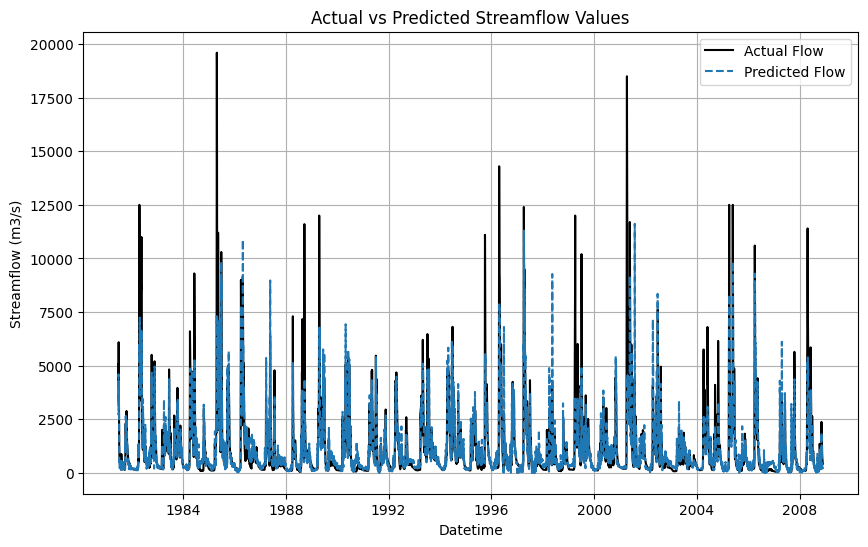

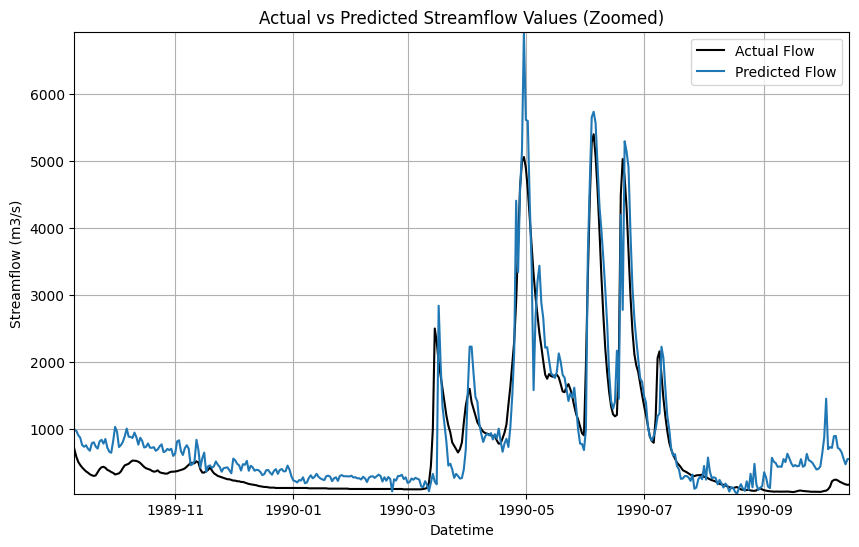

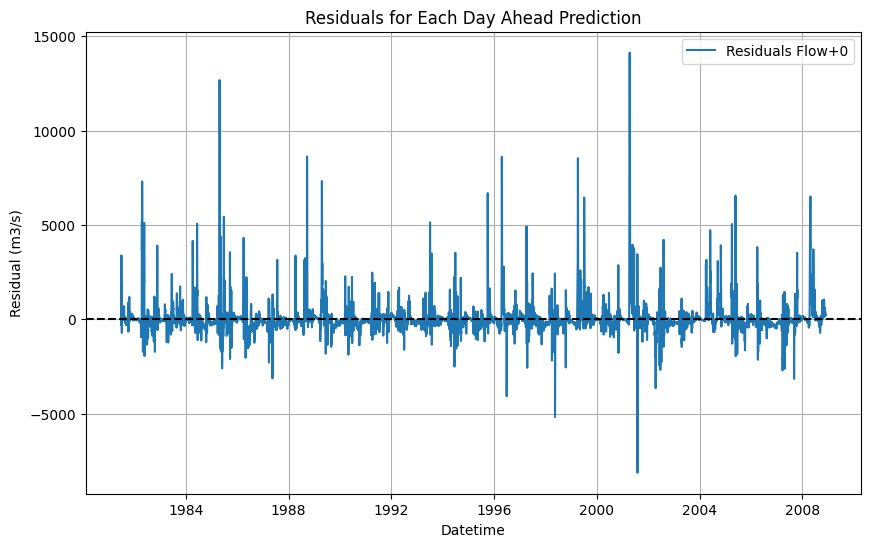

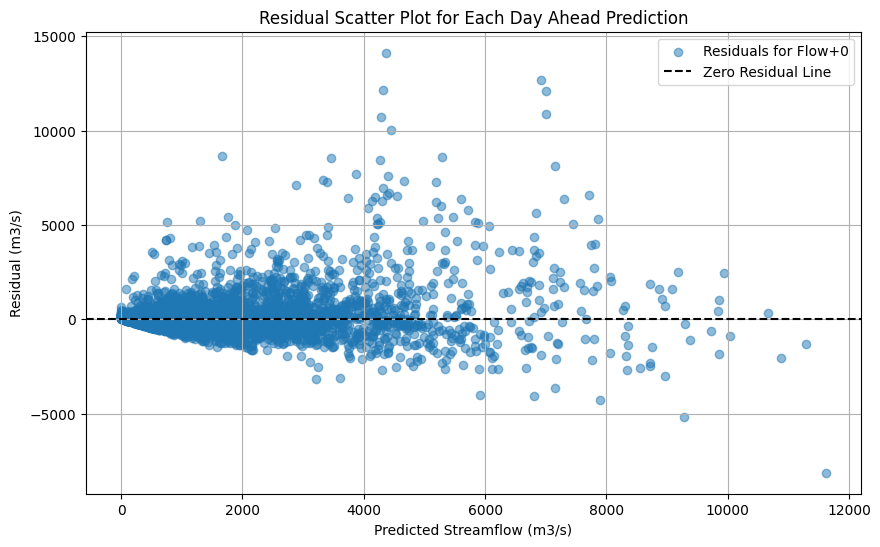

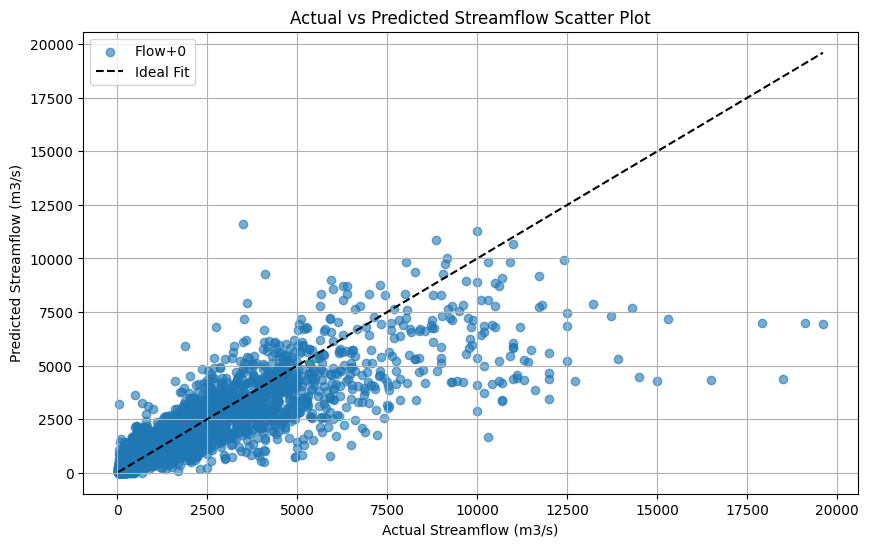

Layer 1: lstm_4
  Weights shape: (1, 200)
  Weights: [[-2.05292786e-03  6.55074604e-04 -2.72704083e-02  1.49987983e-02
  -7.97099154e-03  1.19966799e-02 -1.07323928e-02  1.49709024e-02
  -8.71766545e-03  9.11391620e-03  1.64818373e-02  4.33199294e-03
  -8.32327269e-03  9.78534482e-03 -2.29616519e-02 -2.10706075e-03
   2.63756281e-03  1.01672728e-02 -1.06201001e-01  4.14318629e-02
  -9.84939281e-03 -5.33281546e-03  4.81310039e-04  6.77363807e-03
   2.16938667e-02 -1.02805346e-02  1.02491472e-02 -1.67675950e-02
  -1.13229016e-02  1.41072727e-03 -2.38279644e-02  2.22626310e-02
   2.29905471e-02  2.89386022e-03  5.82926981e-02  1.53515507e-02
   7.28590414e-03  1.18788760e-02  1.60949696e-02 -6.82647573e-03
   2.31402293e-02  2.46683285e-02 -1.53854694e-02  1.00283022e-03
   1.20847544e-04 -5.92866540e-03 -1.11576170e-03 -3.38462815e-02
   6.93349075e-03  1.54197328e-02 -1.78935714e-02  3.59157170e-03
  -2.10187049e-03 -1.43271275e-02 -2.71991417e-02 -7.09795905e-03
  -6.65239431e-03 -8.24

In [50]:
visualization(datetime3, y_pred2, y_test2, 3000, 3400)
print_model_weights_and_biases(model)